# Site Selection Analysis with Geopandas
Geopandas is an extension of pandas used when working with geospatial data. Spatial Analysis has become increasingly relevant to solving world problems and making decision making easier.

In this tutorial, we will do a short analysis using geopandas for manipulation of spatial data with simple calculations to find the euclidean distance of stores from customers. This analysis can be used to optimize retail store placement and assess customer accessibility,

## Installation
Importing necessary libraries we will use for this geospatial analysis.


In [11]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Customer Data Creation
We will create out own sample data to use in this tutorial. We will base our sites and customers from NYC defining the latitude and longitude coordinates.
We will also define neighbourhoods that we will use for clustering. This is because in a real world scenario customer distribution isnʼt uniform around the center. The seed ensures that we can resproduce the random coordinates generated.



In [12]:
def generate_customer_data(num_customers=1000, nairobi_center=(-1.2921, 36.8219)):
  np.random.seed(42)
  # Create neighborhoods that we will use as clusters
  neighborhood_centers = [
      (-1.2667, 36.8000),
      (-1.3400, 36.7500),
      (-1.2200, 36.8900),
      (-1.3200, 36.9200),
      (-1.3000, 36.7700),
      (-1.3100, 36.8500)
    ]
  customers = []
  customer_id = 1

  for center in neighborhood_centers:
        # Generate customers around each neighborhood center
        n_local = np.random.poisson(num_customers // len(neighborhood_centers))

        for _ in range(n_local):
            # Add some randomness around each center
            lat_offset = np.random.normal(0, 0.01)
            lon_offset = np.random.normal(0, 0.01)

            customers.append({
                'customer_id': customer_id,
                'latitude': center[0] + lat_offset,
                'longitude': center[1] + lon_offset,
                'annual_spending': np.random.exponential(2000) + 500,  # Annual spending
                'visit_frequency': np.random.poisson(12) + 1,  # Visits per year
            })
            customer_id += 1

  return pd.DataFrame(customers)

## Store Data Generation
We will create sample data of existing stores. This stores will be the reference to get the distance customers travel to acquire services from the company.

In [13]:
def generate_existing_stores():
    stores=[
      {'store_id': 'SO1', 'name': 'Westlands', 'latitude': -1.2667, 'longitude': 36.8000},
      {'store_id': 'SO2', 'name': 'Nairobi CBD', 'latitude': -1.2921, 'longitude': 36.8219},
      {'store_id': 'SO3', 'name': 'Rongoi', 'latitude': -1.3400, 'longitude': 36.7500}
    ]
    return pd.DataFrame(stores)

In [14]:
# Generate the data
customers_df = generate_customer_data()
stores_df = generate_existing_stores()
print(f"Generated {len(customers_df)} customers and {len(stores_df)} existing stores")

Generated 955 customers and 3 existing stores


Conversion of the dataframes created using pandas to geodataframes using geopandas. We add a geometry column, with point objects created from the latitude and longitude of the customer and store locations.

In [15]:
# Convert Dataframes to GeoDataFrames
customers_gdf = gpd.GeoDataFrame(
    customers_df,
    geometry=gpd.points_from_xy(customers_df.longitude, customers_df.latitude),
    crs='EPSG:4326'
)

stores_gdf = gpd.GeoDataFrame(
    stores_df,
    geometry=gpd.points_from_xy(stores_df.longitude, stores_df.latitude),
    crs='EPSG:4326'
)

In [16]:
print("Customer Summary Statistics:")
print(customers_df[['annual_spending', 'visit_frequency']].describe())

Customer Summary Statistics:
       annual_spending  visit_frequency
count       955.000000       955.000000
mean       2447.725356        13.005236
std        1960.873807         3.554454
min         500.061439         4.000000
25%        1001.043668        11.000000
50%        1844.308318        13.000000
75%        3260.967935        15.000000
max       15178.001134        24.000000


After we are going to compute the distance from each customer to the nearest store and adds this information to the customers to the geodataframe.
In the function we start by converting projection from lat/lon to Web Mercator. This is because it is easier calculating distances using metres than using degrees. We use the cdist function from SciPy to calculate the Euclidean distance matrix between all customers and stores.

In [17]:
# Calculations
from scipy.spatial.distance import cdist

In [18]:
# Calculate distances from each customer to nearest store
def calculate_distances_to_stores(customers_gdf, stores_gdf):

    # Convert to projected CRS
    customers_proj = customers_gdf.to_crs('EPSG:3857')
    stores_proj = stores_gdf.to_crs('EPSG:3857')

    # Save the coordinates of customer and coordinates as separate numpy arrays
    customer_coords = np.array([[point.x, point.y] for point in customers_proj.geometry])
    store_coords = np.array([[point.x, point.y] for point in stores_proj.geometry])

    # Distance matrix in meters using cdist
    distances = cdist(customer_coords, store_coords)

    # Finding the nearest store for each customer and the distance to the store
    nearest_store_idx = np.argmin(distances, axis=1)
    nearest_store_distance = np.min(distances, axis=1)

    # Add results to customers dataframe
    customers_gdf['nearest_store_id'] = stores_gdf.iloc[nearest_store_idx]['store_id'].values
    customers_gdf['nearest_store_distance_m'] = nearest_store_distance
    customers_gdf['nearest_store_distance_km'] = nearest_store_distance / 1000

    return customers_gdf

customers_gdf = calculate_distances_to_stores(customers_gdf, stores_gdf)


Now having the distance between the customers and stores, we can identify and quantify demand. This information helps understand locations that would help the accessibility of the stores to people.

In [21]:
# 4. Customer distribution

print(f"Average distance to nearest store: {customers_gdf['nearest_store_distance_km'].mean():.2f} km")
print(f"Median distance to nearest store: {customers_gdf['nearest_store_distance_km'].median():.2f} km")
print(f"Max distance to nearest store: {customers_gdf['nearest_store_distance_km'].max():.2f} km")

# Customers more than 2km from nearest store (underserved)
underserved = customers_gdf[customers_gdf['nearest_store_distance_km'] > 4.0]
print(f"Underserved customers (>4km from store): {len(underserved)} ({len(underserved)/len(customers_gdf)*100:.1f}%)")

Average distance to nearest store: 5.61 km
Median distance to nearest store: 4.24 km
Max distance to nearest store: 14.41 km
Underserved customers (>4km from store): 502 (52.6%)


## Visualization of customer distribution
To understand customer distribution, store performance, and relationships between distance and spending we can visualize in sub-plots. 2x2



🏪 Store Performance Analysis:
                  Customer_Count  Total_Revenue  Avg_Spending  Avg_Distance
nearest_store_id                                                           
SO1                          250      585452.50       2341.81          3.19
SO2                          472     1169377.52       2477.49          8.52
SO3                          233      582747.70       2501.06          2.31


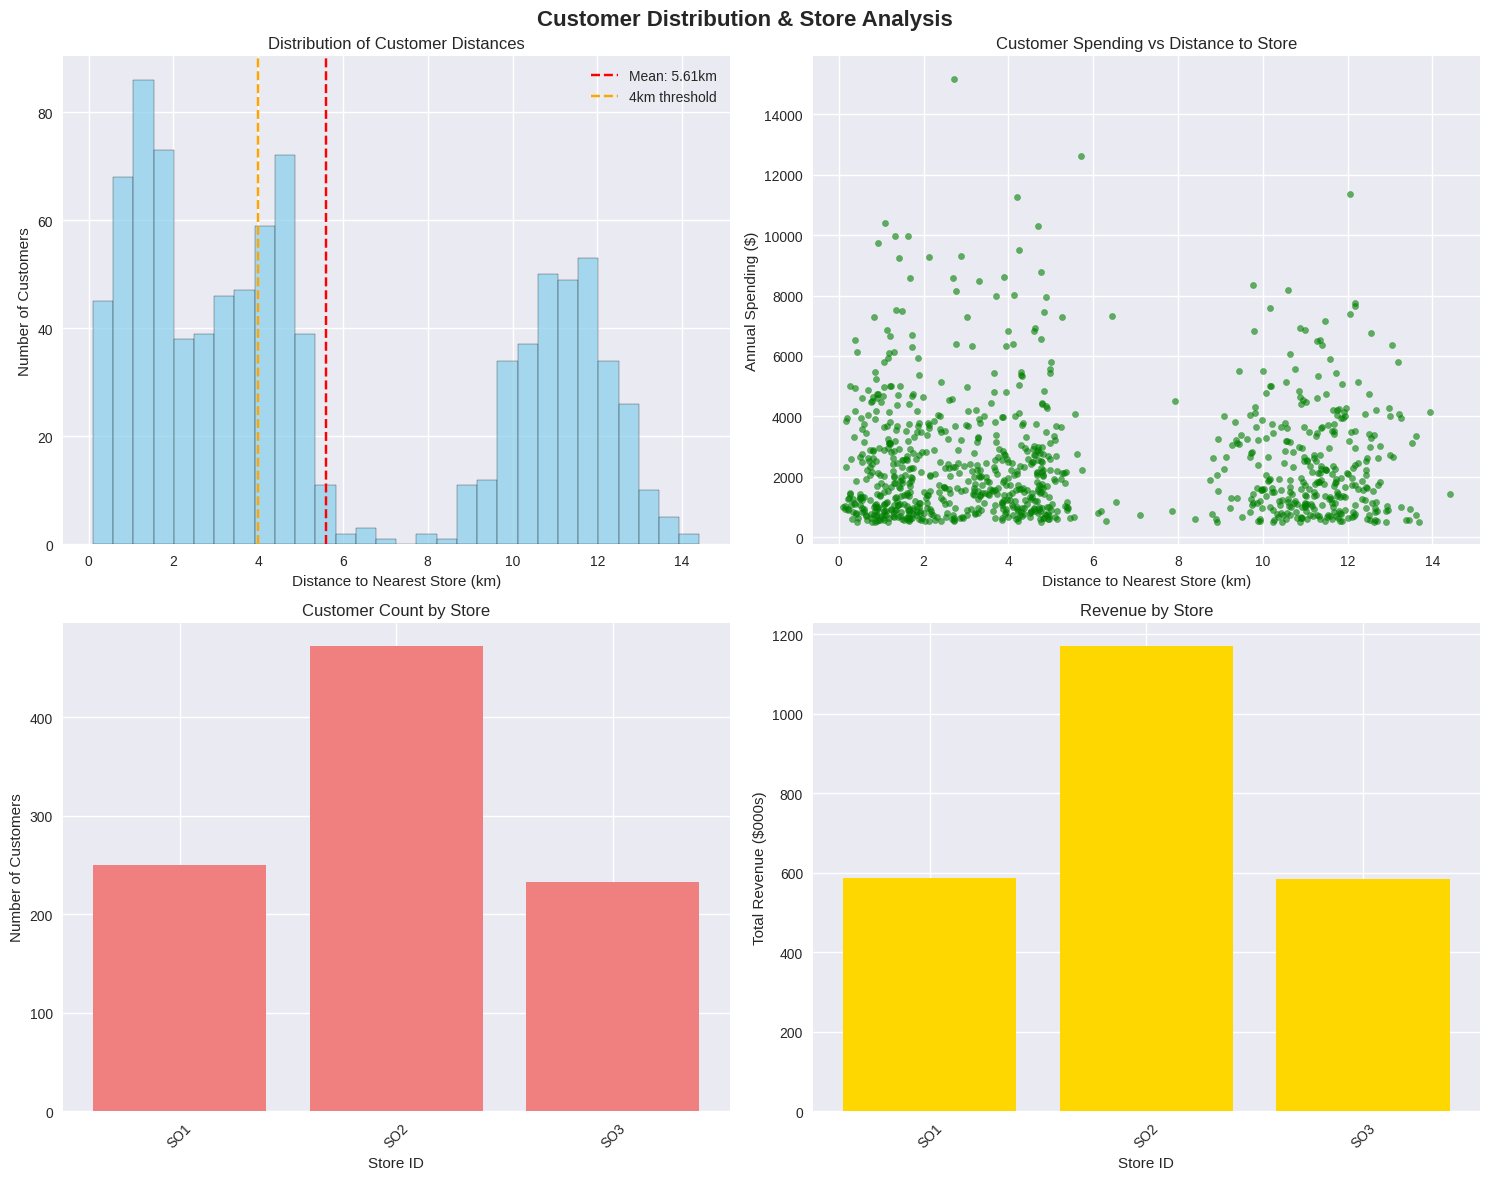

In [22]:
# 5. Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Customer Distribution & Store Analysis', fontsize=16, fontweight='bold')

# Distance distribution
axes[0,0].hist(customers_gdf['nearest_store_distance_km'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(customers_gdf['nearest_store_distance_km'].mean(), color='red', linestyle='--', label=f'Mean: {customers_gdf["nearest_store_distance_km"].mean():.2f}km')
axes[0,0].axvline(4.0, color='orange', linestyle='--', label='4km threshold')
axes[0,0].set_xlabel('Distance to Nearest Store (km)')
axes[0,0].set_ylabel('Number of Customers')
axes[0,0].set_title('Distribution of Customer Distances')
axes[0,0].legend()

# Spending vs Distance
axes[0,1].scatter(customers_gdf['nearest_store_distance_km'], customers_gdf['annual_spending'],
                 alpha=0.6, s=20, c='green')
axes[0,1].set_xlabel('Distance to Nearest Store (km)')
axes[0,1].set_ylabel('Annual Spending ($)')
axes[0,1].set_title('Customer Spending vs Distance to Store')

# Store catchment analysis
store_catchment = customers_gdf.groupby('nearest_store_id').agg({
    'customer_id': 'count',
    'annual_spending': ['sum', 'mean'],
    'nearest_store_distance_km': 'mean'
}).round(2)

store_catchment.columns = ['Customer_Count', 'Total_Revenue', 'Avg_Spending', 'Avg_Distance']
print("\n🏪 Store Performance Analysis:")
print(store_catchment)

# Bar plot of customers per store
axes[1,0].bar(store_catchment.index, store_catchment['Customer_Count'], color='lightcoral')
axes[1,0].set_xlabel('Store ID')
axes[1,0].set_ylabel('Number of Customers')
axes[1,0].set_title('Customer Count by Store')
axes[1,0].tick_params(axis='x', rotation=45)

# Revenue per store
axes[1,1].bar(store_catchment.index, store_catchment['Total_Revenue']/1000, color='gold')
axes[1,1].set_xlabel('Store ID')
axes[1,1].set_ylabel('Total Revenue ($000s)')
axes[1,1].set_title('Revenue by Store')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()